# Snow extent boxplots and errors calculations

## Objective

The goal of this notebook is to compare the snow cover simulated by each model with the observed data. At the same time, absolute errors will be calculated and compared. This will allow us to identify outlier models that should be excluded or given less weight in future analyses. Finally, various scoring functions have been tested to determine which one penalizes poor models the most. Therefore, this notebook presents the complete set of statistical analyses.

In [22]:
from watermark import watermark
%load_ext watermark
print(watermark())

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-07-10T09:12:52.543139+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-63-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [23]:
import sys
import os

# absolute path to the folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# adding the path to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Projet root ajouté au path:", project_root)

Projet root ajouté au path: /home/jovyan/M2_Internship_Laurie_Vayssettes


In [24]:
from module import *

In [25]:
%watermark --iversions

netCDF4   : 1.7.2
xesmf     : 0.8.8
skimage   : 0.25.0
sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
csv       : 1.0
pandas    : 2.2.3
numpy     : 2.0.2
seaborn   : 0.13.2
cartopy   : 0.24.0
xarray    : 2025.1.1
watermark : 2.5.0
cdo       : 1.6.1
matplotlib: 3.10.0



## Snow reference

In [26]:
# reference grid
path = "/home/jovyan/shared-storage/Data_LaurieV/input_data/grid/"
file = "nhsce_mon.v01r01_19661004_20250303_1.0x1.0.nc"
ref_grid = xr.open_dataset(os.path.join(path, file))

In [27]:
# good areas 
path = "/home/jovyan/shared-storage/Data_LaurieV/input_data/grid/"
file = "area.nc"
area = xr.open_dataset(os.path.join(path, file))

In [28]:
# selection of the reference period
ref_grid = ref_grid.sel(time=slice("1995", "2014"))

### Snow extension by month

In [29]:
# variable selection for the reference
snow_cover = ref_grid["snow_cover_extent"]

# monthly mean
snow_cover = snow_cover.groupby("time.month").mean(dim="time")

In [30]:
# variable selection for the area
cell_area = area["cell_area"]

# sno cover calculation in km2
snow_cover_km2 = (snow_cover * (cell_area * 1e-6) ).groupby(snow_cover["month"]).sum(dim=["lat", "lon"], skipna=True)

print(snow_cover_km2)
print(snow_cover_km2.shape)

<xarray.DataArray (month: 12)> Size: 96B
array([47527339.11645807, 47170685.33438697, 41034269.29181223,
       32014146.33675294, 19553457.31518154,  9003870.52668834,
        3134122.09805531,  2460193.82986189,  4226952.56887794,
       17861365.62524626, 34152238.95970662, 44012796.3253699 ])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
(12,)


## Visualizing the average monthly snow coverage based on historical data

In [32]:
# open the csv file
snow_hist = pd.read_csv("/home/jovyan/shared-storage/Data_LaurieV/output_data2/snow_cover_per_model.csv")
snow_hist

,modèle,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,BCC-CSM2-MR,4.437375e+07,4.455293e+07,4.119390e+07,3.309121e+07,2.124193e+07,9.921411e+06,5.103984e+06,4.124143e+06,5.976217e+06,1.615822e+07,2.839227e+07,3.903006e+07
1,CanESM5,4.981547e+07,5.075868e+07,4.659704e+07,3.673196e+07,2.277091e+07,9.093042e+06,3.651710e+06,3.057670e+06,5.027469e+06,1.660451e+07,3.249887e+07,4.362006e+07
2,CanESM5-CanOE,4.999035e+07,5.084355e+07,4.700303e+07,3.749724e+07,2.321667e+07,9.372791e+06,3.762655e+06,3.022692e+06,5.274633e+06,1.694431e+07,3.321003e+07,4.449164e+07
3,CESM2,4.521618e+07,4.505156e+07,3.935448e+07,2.876052e+07,1.729612e+07,8.956349e+06,4.508116e+06,3.205743e+06,5.010174e+06,1.482841e+07,2.807783e+07,3.894232e+07
4,CESM2-WACCM,4.482860e+07,4.526281e+07,4.014056e+07,3.024475e+07,1.858542e+07,9.614281e+06,4.681767e+06,3.305975e+06,5.391870e+06,1.543980e+07,2.772955e+07,3.884835e+07
5,CIESM,4.772395e+07,4.634545e+07,4.033531e+07,2.914981e+07,1.660809e+07,5.306691e+06,1.942934e+06,1.509078e+06,2.631251e+06,1.352317e+07,3.092356e+07,4.299549e+07
6,CNRM-CM6-1,5.582132e+07,5.578548e+07,4.856225e+07,3.340614e+07,1.736846e+07,5.657832e+06,3.136855e+06,2.885529e+06,5.029636e+06,1.736554e+07,3.553454e+07,4.913415e+07
7,CNRM-CM6-1-HR,5.424420e+07,5.411872e+07,4.791415e+07,3.332174e+07,1.705687e+07,6.009408e+06,3.486442e+06,3.384404e+06,6.117203e+06,1.874844e+07,3.613690e+07,4.875330e+07
8,CNRM-ESM2-1,5.369965e+07,5.340618e+07,4.654606e+07,3.266167e+07,1.640322e+07,5.168239e+06,2.816770e+06,2.508564e+06,4.445377e+06,1.622590e+07,3.331676e+07,4.719822e+07
9,EC-Earth3,5.999824e+07,5.895386e+07,5.451853e+07,4.589171e+07,3.338828e+07,1.958966e+07,7.544348e+06,7.344999e+06,1.731407e+07,3.537745e+07,4.913663e+07,5.775572e+07


### Adding a reference to this DataFrame and calculating the annual average

In [33]:
# List of months
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Add the "reference" row
reference_row = {"modèle": "reference"}
reference_row.update({month: val for month, val in zip(month_names, snow_cover_km2.values)})

# Append the row to the existing DataFrame
snow_hist = pd.concat([snow_hist, pd.DataFrame([reference_row])], ignore_index=True)

# Add a column for the annual average
snow_hist["ann"] = snow_hist[month_names].mean(axis=1)

In [34]:
# Display the last rows of the DataFrame for verification
snow_hist.tail()

,modèle,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,ann
21,NorESM2-LM,4.613841e+07,4.584898e+07,4.076986e+07,3.142475e+07,1.985538e+07,1.092033e+07,5.662918e+06,4.244550e+06,5.785222e+06,1.570454e+07,2.943020e+07,4.033246e+07,2.467647e+07
22,NorESM2-MM,4.616538e+07,4.590423e+07,4.087167e+07,3.086751e+07,1.924104e+07,1.050969e+07,6.135272e+06,4.861130e+06,6.968939e+06,1.717549e+07,3.005232e+07,4.027045e+07,2.491859e+07
23,UKESM1-0-LL,4.917915e+07,4.758195e+07,4.332229e+07,3.364535e+07,2.184443e+07,1.139703e+07,3.728455e+06,4.669178e+06,1.327104e+07,2.486453e+07,3.874044e+07,4.707890e+07,2.827690e+07
24,IPSL-CM6A-LR,5.063182e+07,4.982092e+07,4.432254e+07,3.238736e+07,1.645353e+07,6.659042e+06,4.814387e+06,4.667036e+06,6.063171e+06,1.721438e+07,3.369102e+07,4.544916e+07,2.601453e+07
25,reference,4.752734e+07,4.717069e+07,4.103427e+07,3.201415e+07,1.955346e+07,9.003871e+06,3.134122e+06,2.460194e+06,4.226953e+06,1.786137e+07,3.415224e+07,4.401280e+07,2.517929e+07


In [35]:
# Convert to long format
snow_hist_long = snow_hist.melt(id_vars='modèle', var_name='Month', value_name='snow_extent')
snow_hist_long

,modèle,Month,snow_extent
0,BCC-CSM2-MR,jan,4.437375e+07
1,CanESM5,jan,4.981547e+07
2,CanESM5-CanOE,jan,4.999035e+07
3,CESM2,jan,4.521618e+07
4,CESM2-WACCM,jan,4.482860e+07
...,...,...,...
333,NorESM2-LM,ann,2.467647e+07
334,NorESM2-MM,ann,2.491859e+07
335,UKESM1-0-LL,ann,2.827690e+07
336,IPSL-CM6A-LR,ann,2.601453e+07


In [36]:
# Extract reference data
ref_data = snow_hist_long[snow_hist_long['modèle'] == 'reference']
ref_data

,modèle,Month,snow_extent
25,reference,jan,4.752734e+07
51,reference,feb,4.717069e+07
77,reference,mar,4.103427e+07
103,reference,apr,3.201415e+07
129,reference,may,1.955346e+07
155,reference,jun,9.003871e+06
181,reference,jul,3.134122e+06
207,reference,aug,2.460194e+06
233,reference,sep,4.226953e+06
259,reference,oct,1.786137e+07


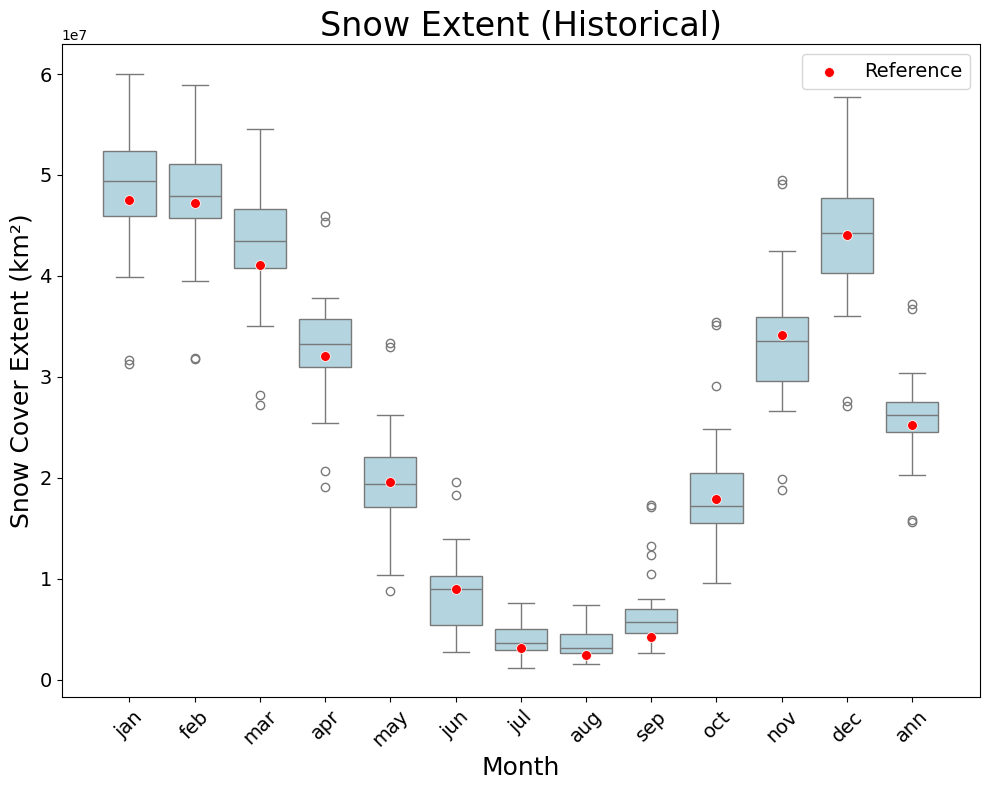

In [37]:
# Generate a boxplot of monthly snow extent using historical data, comparing it with the reference dataset
plot_monthly_snow_boxplot(
    df_long=snow_hist_long,
    reference_df=ref_data,
    title="Snow Extent (Historical)",
    save_path=None  # or "figures/historical_snow_extent.png" (if you want to save the figure)
)

Boxplot showing the monthly distribution of snow extent from historical data. 

The reference data is highlighted for comparison. In this figure, we can see that the reference data (red points) generally lies well within the ranges defined by the models, indicating good agreement between observations and simulations. However, we also notice that many points fall outside the boxes’ ranges—these are the outliers identified in this analysis.

### Identification of outliers

In [38]:
# Calculate outliers present in the figure above
outliers = []

# Detect outliers for each month
for mois in snow_hist_long['Month'].unique():
    valeurs = snow_hist_long[snow_hist_long['Month'] == mois]['snow_extent']
    q1 = valeurs.quantile(0.25)
    q3 = valeurs.quantile(0.75)
    iqr = q3 - q1 #(interquantile range)
    seuil_bas = q1 - 1.5 * iqr
    seuil_haut = q3 + 1.5 * iqr

    # Select outliers
    outliers_mois = snow_hist_long[
        (snow_hist_long['Month'] == mois) &
        ((snow_hist_long['snow_extent'] < seuil_bas) | (snow_hist_long['snow_extent'] > seuil_haut))
    ]
    outliers.append(outliers_mois)

# Combine all monthly outliers into a single DataFrame
outliers_df = pd.concat(outliers)

In [39]:
# Display outliers
outliers_df

,modèle,Month,snow_extent
18,MPI-ESM1-2-HR,jan,3.170003e+07
19,MPI-ESM1-2-LR,jan,3.125102e+07
44,MPI-ESM1-2-HR,feb,3.174476e+07
45,MPI-ESM1-2-LR,feb,3.181366e+07
70,MPI-ESM1-2-HR,mar,2.720010e+07
71,MPI-ESM1-2-LR,mar,2.820279e+07
87,EC-Earth3,apr,4.589171e+07
88,EC-Earth3-Veg,apr,4.531498e+07
96,MPI-ESM1-2-HR,apr,1.912685e+07
97,MPI-ESM1-2-LR,apr,2.067369e+07


This table shows which models fall outside the interval, specifying for each the month and the corresponding snow cover value.

### Calculation of absolute errors

In [40]:
# Create a new DataFrame by merging with reference data on 'Month'
df_avec_erreur = snow_hist_long.merge(ref_data, on='Month', how='left')
df_avec_erreur

,modèle_x,Month,snow_extent_x,modèle_y,snow_extent_y
0,BCC-CSM2-MR,jan,4.437375e+07,reference,4.752734e+07
1,CanESM5,jan,4.981547e+07,reference,4.752734e+07
2,CanESM5-CanOE,jan,4.999035e+07,reference,4.752734e+07
3,CESM2,jan,4.521618e+07,reference,4.752734e+07
4,CESM2-WACCM,jan,4.482860e+07,reference,4.752734e+07
...,...,...,...,...,...
333,NorESM2-LM,ann,2.467647e+07,reference,2.517929e+07
334,NorESM2-MM,ann,2.491859e+07,reference,2.517929e+07
335,UKESM1-0-LL,ann,2.827690e+07,reference,2.517929e+07
336,IPSL-CM6A-LR,ann,2.601453e+07,reference,2.517929e+07


In [41]:
# Calculate the absolute error (simulated snow - reference snow)
df_avec_erreur['Erreur_absolue'] = (df_avec_erreur['snow_extent_x'] - df_avec_erreur['snow_extent_y']).abs()

#### Visualize as a heatmap

In [42]:
# Force the order of months to avoid alphabetical sorting
ordre_mois = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
              'sep', 'oct', 'nov', 'dec', 'ann']

# Reshape data from long to wide format
df_absolu = df_avec_erreur[df_avec_erreur['modèle_x'] !='reference'].pivot(index='modèle_x', columns='Month', values='Erreur_absolue')
df_absolu = df_absolu[ordre_mois]

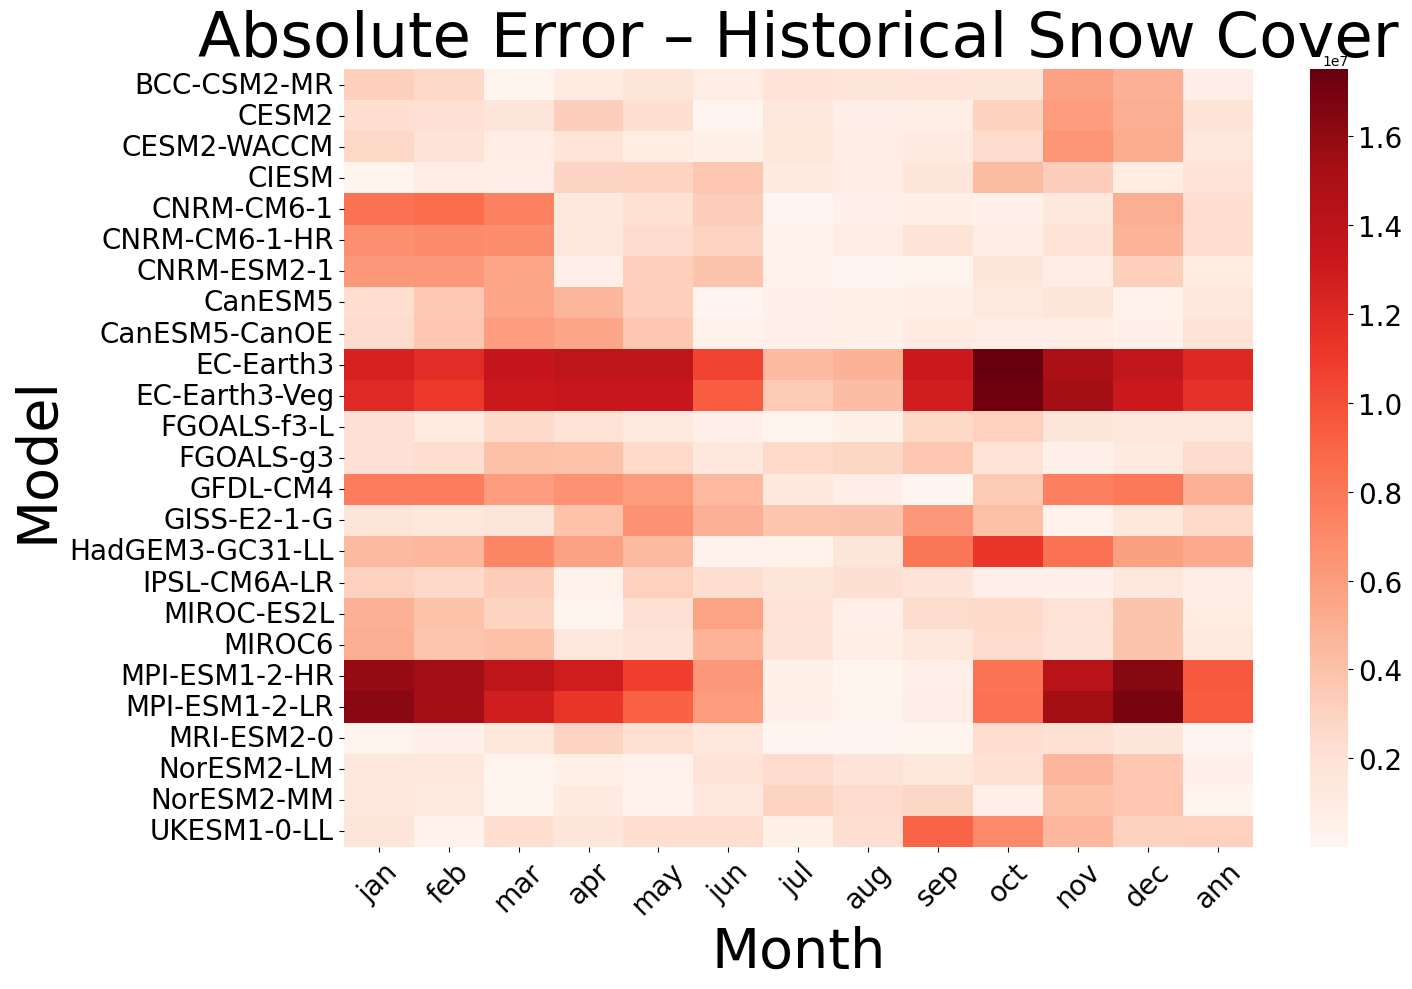

In [43]:
# Plot a heatmap of absolute errors in historical snow cover
plot_heatmap_errors(
    data=df_absolu,
    title="Absolute Error – Historical Snow Cover",
    fontsize_title=45,
    fontsize_labels=40,
    fontsize_ticks=20,
    save_path=None  # or 'figures/absolute_error_historical.png'
)

Absolute Errors in Snow Cover Compared to Reference (Historical Data).

This figure shows the absolute errors in snow cover relative to the reference values, calculated for each model and month. The visualization provides a quick overview of which models and months exhibit poor snow simulation (highlighted by intense red areas). Notably, two groups of models, EC-Earth and MPI-ESM1-2, show significant discrepancies. Identifying these models is important to give them less weight in future analyses.

### Calculation of relative errors

In [44]:
# Calculation of relative errors (in %)
df_avec_erreur['Erreur_relative'] = (((df_avec_erreur['snow_extent_x'] - df_avec_erreur['snow_extent_y'])/df_avec_erreur['snow_extent_y'])*100).abs()

#### Visualize as a heatmap

In [45]:
# Convert data from long to wide format
df_relative = df_avec_erreur[df_avec_erreur['modèle_x'] !='reference'].pivot(index='modèle_x', columns='Month', values='Erreur_relative')
df_relative = df_relative[ordre_mois]

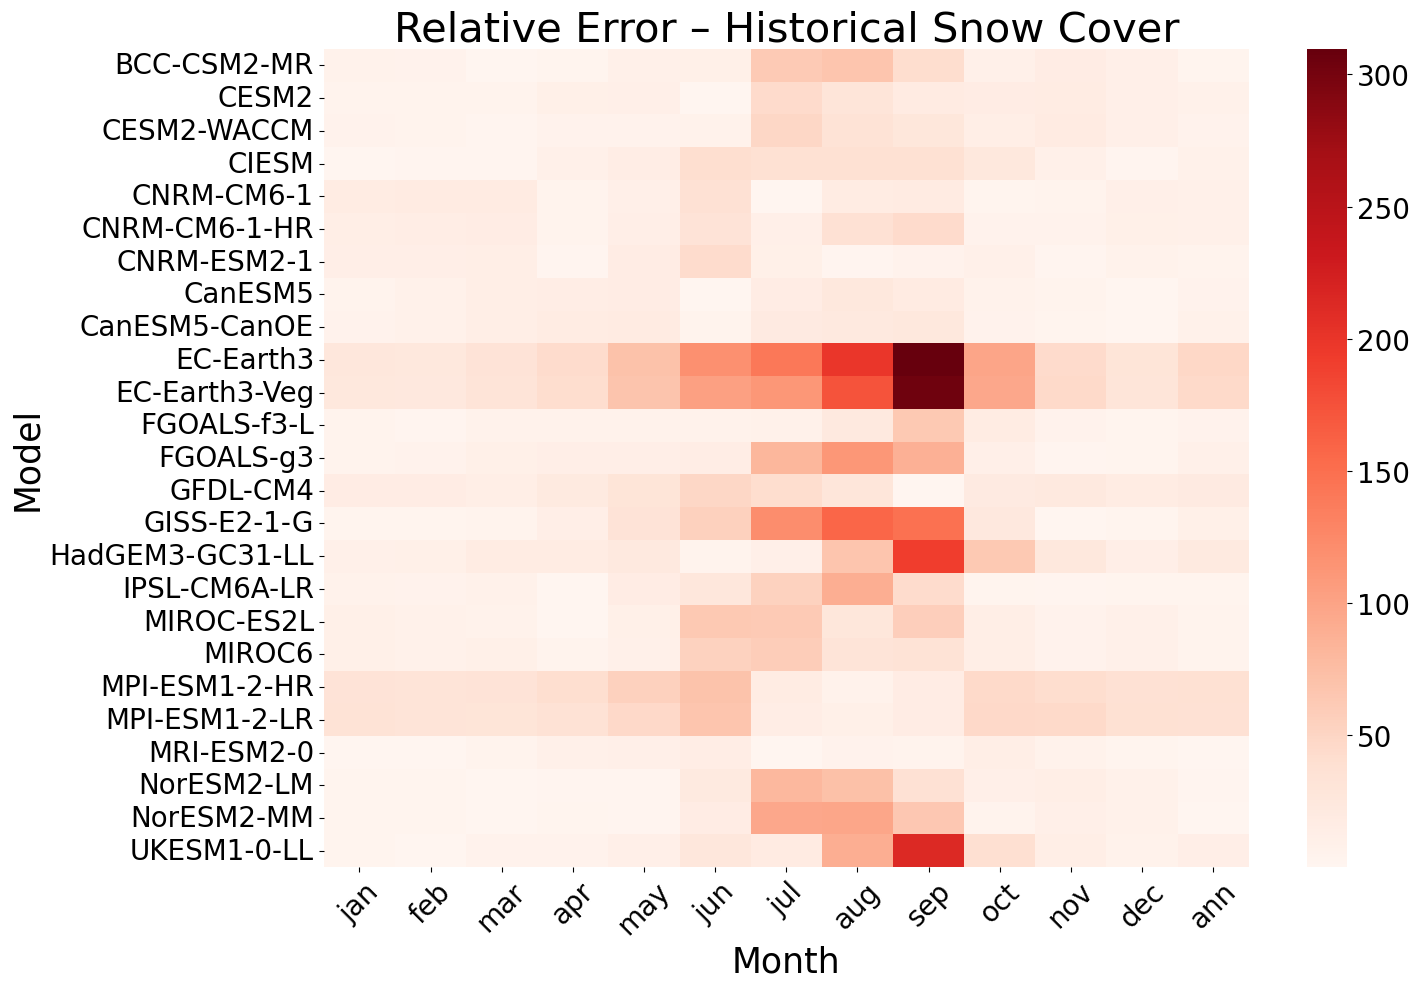

In [46]:
#Plot a heatmap of relative errors in historical snow cover
plot_heatmap_errors(
    data=df_relative,
    title="Relative Error – Historical Snow Cover",
    fontsize_title=30,
    fontsize_labels=25,
    fontsize_ticks=20,
    save_path=None  # ou 'figures/absolute_error_historical.png'
)

Relative Errors in Snow Cover Compared to Reference (Historical Data). 

This figure shows the relative errors. We can see that these errors are particularly large during the summer for most models. On an annual basis, the same models as before exhibit the highest errors.

## Determine the ranking of each model

To identify the best and worst models, we rank them based on their absolute errors.

In [47]:
# Drop annual values and display last rows
erreurs_absolues_mensuelles_hist = df_absolu.drop(columns=['ann'])
erreurs_absolues_mensuelles_hist.tail()

Month,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
modèle_x,,,,,,,,,,,,
MPI-ESM1-2-LR,1.627631e+07,1.535703e+07,1.283148e+07,1.134046e+07,9.163899e+06,6.051203e+06,4.605887e+05,2.492710e+05,7.028639e+05,8.319699e+06,1.536306e+07,1.691201e+07
MRI-ESM2-0,2.728096e+05,4.150116e+05,1.570946e+06,2.981525e+06,2.156461e+06,1.393279e+06,1.933865e+04,1.290249e+05,1.570928e+05,2.394788e+06,2.134144e+06,1.579312e+06
NorESM2-LM,1.388927e+06,1.321705e+06,2.644078e+05,5.893945e+05,3.019196e+05,1.916460e+06,2.528796e+06,1.784357e+06,1.558269e+06,2.156828e+06,4.722039e+06,3.680336e+06
NorESM2-MM,1.361964e+06,1.266455e+06,1.626014e+05,1.146634e+06,3.124203e+05,1.505824e+06,3.001150e+06,2.400936e+06,2.741986e+06,6.858776e+05,4.099914e+06,3.742342e+06
UKESM1-0-LL,1.651814e+06,4.112674e+05,2.288024e+06,1.631201e+06,2.290977e+06,2.393157e+06,5.943325e+05,2.208984e+06,9.044087e+06,7.003168e+06,4.588204e+06,3.066099e+06


In [48]:
# Compute the mean of absolute errors
classement_modeles = erreurs_absolues_mensuelles_hist.mean(axis=1)

In [49]:
# Sort the values in ascending order
classement_modeles.sort_values(ascending=True, inplace=True)
print(classement_modeles)

modèle_x
MRI-ESM2-0         1.266978e+06
FGOALS-f3-L        1.609116e+06
NorESM2-LM         1.851120e+06
NorESM2-MM         1.869009e+06
IPSL-CM6A-LR       1.927405e+06
CIESM              1.962490e+06
CanESM5            2.056824e+06
CanESM5-CanOE      2.183057e+06
CESM2-WACCM        2.201267e+06
BCC-CSM2-MR        2.286914e+06
CESM2              2.395764e+06
FGOALS-g3          2.430790e+06
CNRM-ESM2-1        2.649459e+06
MIROC6             2.782514e+06
MIROC-ES2L         2.791986e+06
UKESM1-0-LL        3.097610e+06
CNRM-CM6-1-HR      3.176870e+06
CNRM-CM6-1         3.299169e+06
GISS-E2-1-G        3.367435e+06
GFDL-CM4           4.964078e+06
HadGEM3-GC31-LL    5.206403e+06
MPI-ESM1-2-LR      9.418989e+06
MPI-ESM1-2-HR      9.600430e+06
EC-Earth3-Veg      1.154588e+07
EC-Earth3          1.205517e+07
dtype: float64


Here, the models are ranked in ascending order based on their absolute error values. The first model has the lowest error, and the last one the highest.

## Assigning a score to each model

Based on the mean absolute errors, a ranking can be assigned to each model. Two different scoring functions have been tested: an exponential function and a Gaussian-type function.

### Decreasing exponential

In [51]:
# Compute the scores by the exponential scoring function
scores_exp = scores_exp_normalises(classement_modeles)
print(scores_exp)

modèle_x
MRI-ESM2-0         1.000000
FGOALS-f3-L        0.968783
NorESM2-LM         0.947293
NorESM2-MM         0.945724
IPSL-CM6A-LR       0.940619
CIESM              0.937564
CanESM5            0.929402
CanESM5-CanOE      0.918590
CESM2-WACCM        0.917041
BCC-CSM2-MR        0.909790
CESM2              0.900656
FGOALS-g3          0.897737
CNRM-ESM2-1        0.879724
MIROC6             0.868940
MIROC-ES2L         0.868178
UKESM1-0-LL        0.843928
CNRM-CM6-1-HR      0.837750
CNRM-CM6-1         0.828307
GISS-E2-1-G        0.823082
GFDL-CM4           0.709852
HadGEM3-GC31-LL    0.694085
MPI-ESM1-2-LR      0.469709
MPI-ESM1-2-HR      0.461875
EC-Earth3-Veg      0.385663
EC-Earth3          0.367879
dtype: float64


### Adjusted Gaussian

In [52]:
#Compute the scores by the Gaussian-style scoring function
scores_gauss = scores_gaussiens(classement_modeles)
print(scores_gauss)

modèle_x
MRI-ESM2-0         1.000000
FGOALS-f3-L        0.991986
NorESM2-LM         0.976818
NorESM2-MM         0.975395
IPSL-CM6A-LR       0.970464
CIESM              0.967296
CanESM5            0.958024
CanESM5-CanOE      0.943948
CESM2-WACCM        0.941764
BCC-CSM2-MR        0.930991
CESM2              0.916144
FGOALS-g3          0.911101
CNRM-ESM2-1        0.876889
MIROC6             0.853953
MIROC-ES2L         0.852264
UKESM1-0-LL        0.794253
CNRM-CM6-1-HR      0.778231
CNRM-CM6-1         0.752864
GISS-E2-1-G        0.738404
GFDL-CM4           0.390808
HadGEM3-GC31-LL    0.344129
MPI-ESM1-2-LR      0.010379
MPI-ESM1-2-HR      0.008450
EC-Earth3-Veg      0.000701
EC-Earth3          0.000335
dtype: float64


In [54]:
mu = classement_modeles.min()
sigma = (classement_modeles.max() - classement_modeles.min())/4

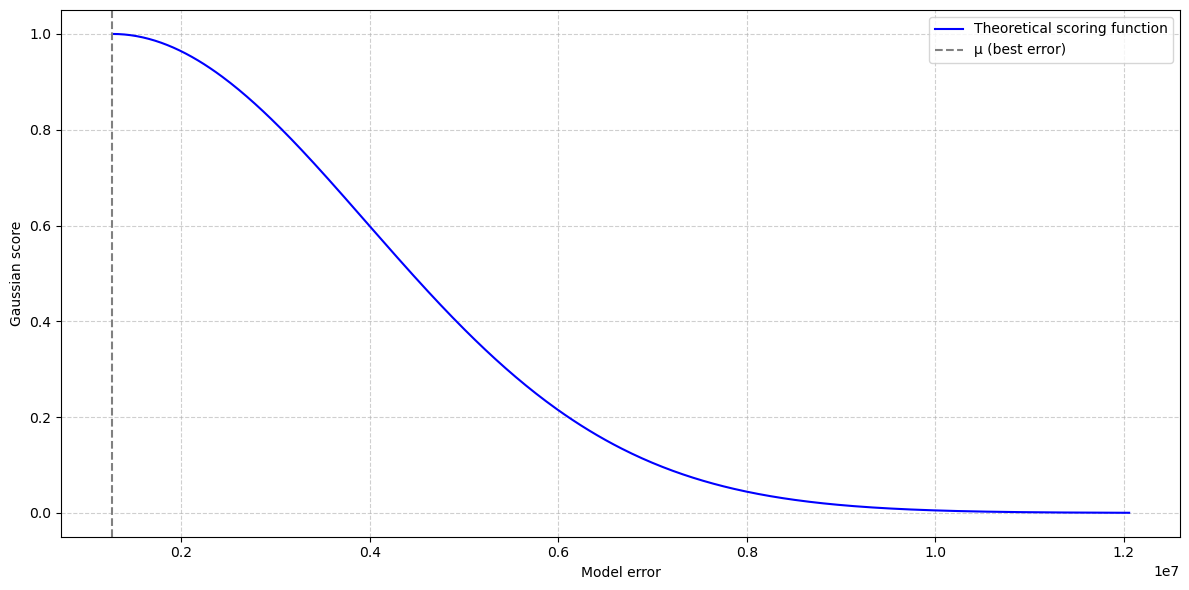

In [55]:
# Generate the theoretical curve
x = np.linspace(classement_modeles.min(), classement_modeles.max(), 500)
gauss_curve = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, gauss_curve, label='Theoretical scoring function', color='blue')
plt.axvline(mu, color='gray', linestyle='--', label='μ (best error)')
plt.xlabel("Model error")
plt.ylabel("Gaussian score")
#plt.title("Gaussian Transformation of Model Errors")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.savefig("courbe_gaussienne.png")
plt.show()

Gaussian Transformation of Model Errors.

This figure illustrates the transformation of model errors using a Gaussian function. The goal is to assign scores to each model, where models with lower errors receive higher scores. The shape of the Gaussian curve ensures that small differences among low-error models are highlighted, while heavily penalizing models with large errors. This approach helps emphasize the best-performing models while down-weighting outliers.

### Create a DataFrame

In [56]:
# Create a DataFrame with error and scores
scores_modeles = pd.DataFrame({
    'Erreur_moyenne' : classement_modeles,
    'Scores_exp' : scores_exp,
    'Scores_gauss' : scores_gauss,
})

In [57]:
# Display the DataFrame
scores_modeles

,Erreur_moyenne,Scores_exp,Scores_gauss
modèle_x,,,
MRI-ESM2-0,1.266978e+06,1.000000,1.000000
FGOALS-f3-L,1.609116e+06,0.968783,0.991986
NorESM2-LM,1.851120e+06,0.947293,0.976818
NorESM2-MM,1.869009e+06,0.945724,0.975395
IPSL-CM6A-LR,1.927405e+06,0.940619,0.970464
CIESM,1.962490e+06,0.937564,0.967296
CanESM5,2.056824e+06,0.929402,0.958024
CanESM5-CanOE,2.183057e+06,0.918590,0.943948
CESM2-WACCM,2.201267e+06,0.917041,0.941764


In [59]:
# Save the DataFrame in a csv format
scores_modeles.to_csv("/home/jovyan/shared-storage/Data_LaurieV/output_data/scores_modeles.csv")

## Conclusion

This notebook has provided a comprehensive analysis of snow cover simulations by various models. It included data visualizations to compare simulated and observed snow extent, identification of outliers to highlight anomalous model behavior, and calculation of absolute and relative errors to quantify model performance. Additionally, models were ranked based on their error metrics, and scoring functions were applied to better distinguish the best and worst performers. Overall, this approach allows for a more informed evaluation and selection of models for future analyses, improving the reliability of snow cover simulations.